In [1]:
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset

In [2]:
dataset_url='http://www.eecs.berkeley.edu/Research/'+\
            'Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
data_dir=tf.keras.utils.get_file(origin=dataset_url,fname='BSR',untar=True)
root_dir=os.path.join(data_dir,'BSDS500/data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])
test_paths[:3]

['/root/.keras/datasets/BSR/BSDS500/data/images/test/100007.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100039.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100099.jpg']

In [3]:
def scale01(input_img):
    return input_img/255
def process_input(input,img_size,upscale_factor):
    input=tf.image.rgb_to_yuv(input)
    last_dimension_axis=len(input.shape)-1
    y,u,v=tf.split(input,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input):
    input=tf.image.rgb_to_yuv(input)
    last_dimension_axis=len(input.shape)-1
    y,u,v=tf.split(input,3,axis=last_dimension_axis)
    return y    

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


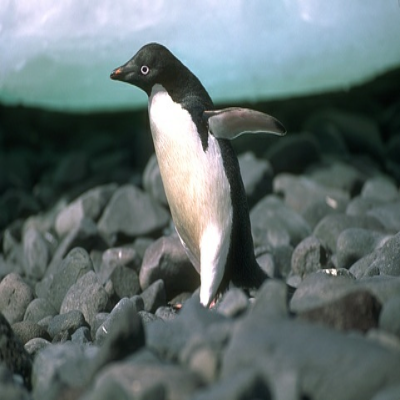

In [4]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=123,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img)); break

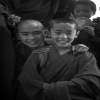

===> ===> ===> 


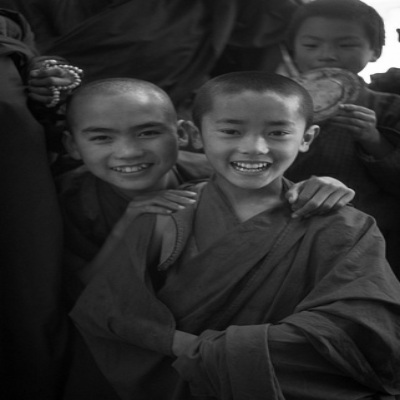

In [5]:
train_ds=train_ds.map(
    lambda x:(process_input(x,input_size,upscale_factor),
              process_target(x)))
train_ds=train_ds.prefetch(buffer_size=32)
valid_ds=valid_ds.map(
    lambda x:(process_input(x,input_size,upscale_factor),
              process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=32)
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img)); break
    print(3*'===> ')
    for img in batch[1]:
        display(array_to_img(img)); break

In [6]:
def get_model(upscale_factor=3,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
    x=tkl.Conv2D(128,5,**conv_args)(inputs)
    x=tkl.Conv2D(64,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [7]:
def plot_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=1,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'-'+title+'.png')
    pl.show()
def get_lowres_image(img, upscale_factor):
    return img.resize(
        (img.size[0]//upscale_factor,img.size[1]//upscale_factor),
         PIL.Image.BICUBIC,)
def upscale_image(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input=np.expand_dims(y,axis=0)
    out=model.predict(input)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [8]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=get_lowres_image(
            load_img(test_paths[0]),upscale_factor)
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if (epoch+1)%25==0:
            prediction=upscale_image(self.model,self.test_img)
            plot_results(prediction,'epoch-'+str(epoch),'prediction')
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [9]:
early_stopping=tkc.EarlyStopping(monitor='loss',patience=10)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)
model=get_model(upscale_factor=upscale_factor,channels=1)
model.summary()
callbacks=[ESPCNCallback(),early_stopping,checkpoint]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 128)   3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 231,280
Trainable params: 231,280
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
50/50 - 5s - loss: 0.0348 - val_loss: 0.0080
mean PSNR for epoch: 21.03

Epoch 00001: loss improved from inf to 0.03482, saving model to /tmp/checkpoint
Epoch 2/100
50/50 - 3s - loss: 0.0062 - val_loss: 0.0065
mean PSNR for epoch: 21.92

Epoch 00002: loss improved from 0.03482 to 0.00616, saving model to /tmp/checkpoint
Epoch 3/100
50/50 - 3s - loss: 0.0047 - val_loss: 0.0044
mean PSNR for epoch: 23.70

Epoch 00003: loss improved from 0.00616 to 0.00467, saving model to /tmp/checkpoint
Epoch 4/100
50/50 - 3s - loss: 0.0037 - val_loss: 0.0042
mean PSNR for epoch: 23.74

Epoch 00004: loss improved from 0.00467 to 0.00367, saving model to /tmp/checkpoint
Epoch 5/100
50/50 - 3s - loss: 0.0033 - val_loss: 0.0034
mean PSNR for epoch: 24.85

Epoch 00005: loss improved from 0.00367 to 0.00334, saving model to /tmp/checkpoint
Epoch 6/100
50/50 - 3s - loss: 0.0031 - val_loss: 0.0046
mean PSNR for epoch: 23.08

Epoch 00006: loss improved from 0.00334 to 0.00310, saving model to /tmp/c

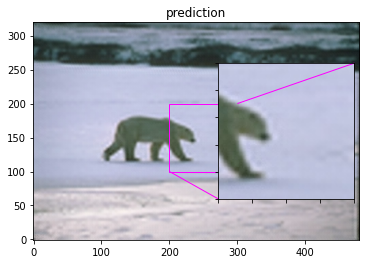


Epoch 00025: loss improved from 0.00259 to 0.00258, saving model to /tmp/checkpoint
Epoch 26/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0029
mean PSNR for epoch: 25.64

Epoch 00026: loss improved from 0.00258 to 0.00258, saving model to /tmp/checkpoint
Epoch 27/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0029
mean PSNR for epoch: 25.46

Epoch 00027: loss improved from 0.00258 to 0.00258, saving model to /tmp/checkpoint
Epoch 28/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0029
mean PSNR for epoch: 25.01

Epoch 00028: loss did not improve from 0.00258
Epoch 29/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0029
mean PSNR for epoch: 25.73

Epoch 00029: loss did not improve from 0.00258
Epoch 30/100
50/50 - 3s - loss: 0.0028 - val_loss: 0.0030
mean PSNR for epoch: 25.04

Epoch 00030: loss did not improve from 0.00258
Epoch 31/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0029
mean PSNR for epoch: 25.35

Epoch 00031: loss did not improve from 0.00258
Epoch 32/100
50/50 - 3s - loss: 0.0026 - va

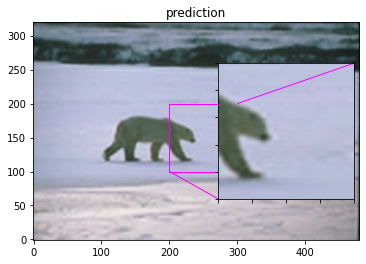


Epoch 00050: loss did not improve from 0.00249
Epoch 51/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.20

Epoch 00051: loss did not improve from 0.00249
Epoch 52/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.45

Epoch 00052: loss improved from 0.00249 to 0.00248, saving model to /tmp/checkpoint
Epoch 53/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.59

Epoch 00053: loss improved from 0.00248 to 0.00248, saving model to /tmp/checkpoint
Epoch 54/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0030
mean PSNR for epoch: 25.48

Epoch 00054: loss did not improve from 0.00248
Epoch 55/100
50/50 - 3s - loss: 0.0032 - val_loss: 0.0028
mean PSNR for epoch: 25.48

Epoch 00055: loss did not improve from 0.00248
Epoch 56/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.53

Epoch 00056: loss did not improve from 0.00248
Epoch 57/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 2

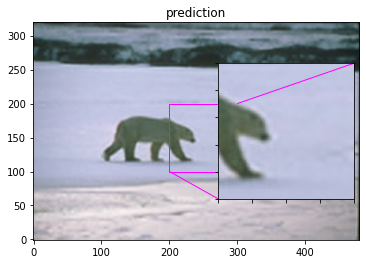


Epoch 00075: loss improved from 0.00243 to 0.00243, saving model to /tmp/checkpoint
Epoch 76/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.85

Epoch 00076: loss improved from 0.00243 to 0.00243, saving model to /tmp/checkpoint
Epoch 77/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.82

Epoch 00077: loss improved from 0.00243 to 0.00242, saving model to /tmp/checkpoint
Epoch 78/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.31

Epoch 00078: loss did not improve from 0.00242
Epoch 79/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.59

Epoch 00079: loss did not improve from 0.00242
Epoch 80/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.19

Epoch 00080: loss did not improve from 0.00242
Epoch 81/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.41

Epoch 00081: loss did not improve from 0.00242
Epoch 82/100
50/50 - 3s - loss: 0.0028 - va

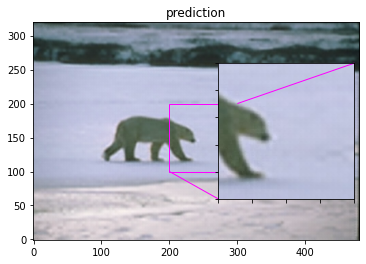


Epoch 00100: loss did not improve from 0.00239


In [10]:
epochs=100
model.compile(optimizer=optimizer,loss=loss_fn,)
model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path)

PSNR of low resolution image and high resolution image is 26.6017
PSNR of predict and high resolution is 27.0336


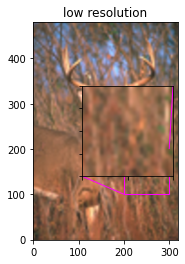

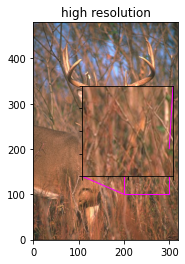

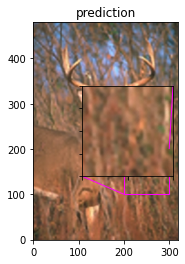

PSNR of low resolution image and high resolution image is 30.3825
PSNR of predict and high resolution is 30.6894


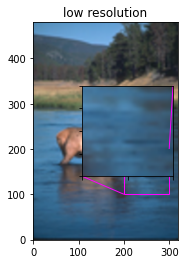

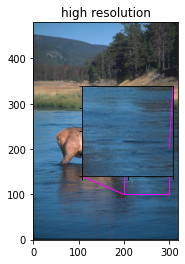

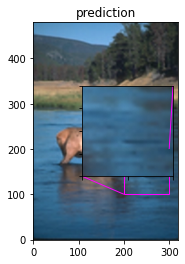

PSNR of low resolution image and high resolution image is 27.5683
PSNR of predict and high resolution is 28.0133


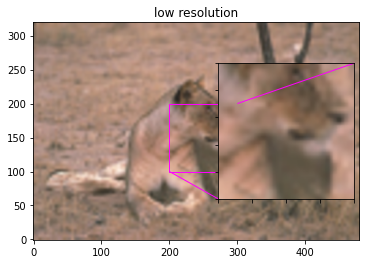

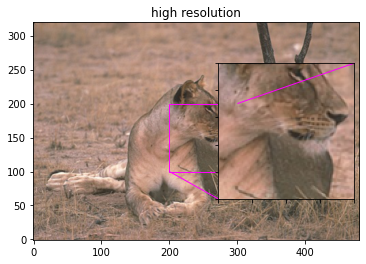

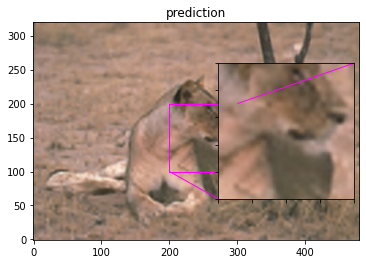

PSNR of low resolution image and high resolution image is 31.4097
PSNR of predict and high resolution is 32.2580


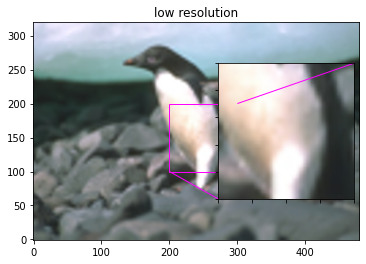

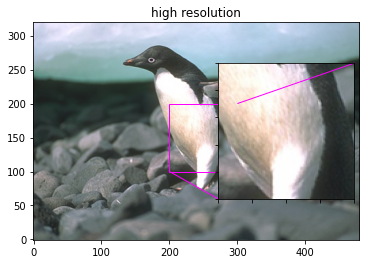

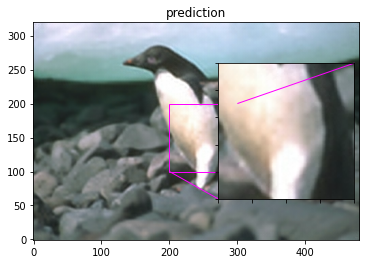

PSNR of low resolution image and high resolution image is 29.9933
PSNR of predict and high resolution is 30.7720


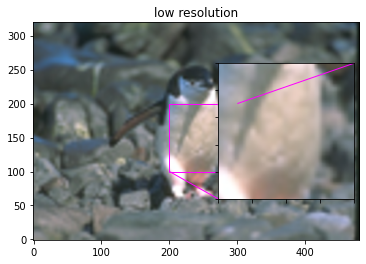

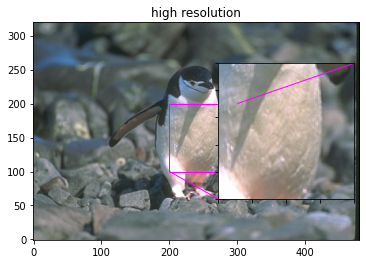

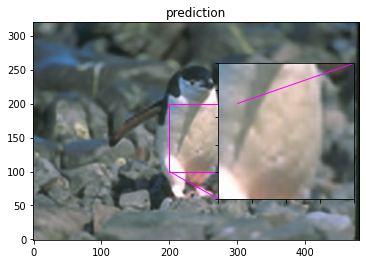

avg. PSNR of lowres images is 14.5955
avg. PSNR of reconstructions is 14.8766


In [11]:
total_bicubic_psnr=0.; total_test_psnr=0.
for index,test_img_path in enumerate(test_paths[10:15]):
    img=load_img(test_img_path)
    lowres_input=get_lowres_image(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    prediction=upscale_image(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(prediction)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution image '+\
          'and high resolution image is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    plot_results(lowres_img,index,'low resolution')
    plot_results(highres_img,index,'high resolution')
    plot_results(prediction,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/10))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/10))